In [1]:
import numpy as np
import pandas as pds
import os

import matplotlib as MP
from matplotlib import pyplot as plt
import seaborn as sbn

data = pds.read_csv(
    '../files/week06/Week 06. data-wine-red.csv',
    delimiter=';'
)

print(data.quality.value_counts())
data.quality -= 3

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


In [27]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import gc; gc.enable()
from itertools import product
from collections import Counter

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.model_selection import KFold

def ss_kfold_fn(data):
    kf = KFold()
    for n, (train_idx, valid_idx) in enumerate(kf.split(data)):
        
        scaler_x = StandardScaler()
        scaler_y = StandardScaler()
        
        train_x = scaler_x.fit_transform(data.iloc[train_idx].drop(columns = 'quality'))
        valid_x = scaler_x.transform(data.iloc[valid_idx].drop(columns = 'quality'))

        train_y = scaler_y.fit_transform(data.iloc[train_idx]['quality'].values.reshape(-1,1))
        valid_y = scaler_y.transform(data.iloc[valid_idx]['quality'].values.reshape(-1,1))
        
        yield n, [
            [train_x, train_y],
            [valid_x, valid_y]
        ], (scaler_x, scaler_y)

In [28]:

logger = dict()
for n, (train_set, valid_set), scaler in ss_kfold_fn(data):
    
    logger[n] = dict()
    
    logger[n]['y_train'] = scaler[1].inverse_transform(
        train_set[1].reshape(-1,1)
    )
    
    logger[n]['y_val'] = scaler[1].inverse_transform(
        valid_set[1].reshape(-1,1)
    )
    
    linear = LinearRegression()
    linear.fit(*train_set)
    logger[n]['linear'] = linear
    logger[n]['y_linear'] = scaler[1].inverse_transform(
        linear.predict(valid_set[0]).reshape(-1,1)
    )

In [12]:
d_ridge = 1e1
d_ridge_range = np.arange(d_ridge, d_ridge * 11, d_ridge)

for n, (train_set, valid_set), scaler in ss_kfold_fn(data):
    
    ridges = []
    ridges_preds = []
    for ridge_lambda in d_ridge_range:
        ridge = Ridge(ridge_lambda)
        ridge.fit(*train_set)
        ridges_preds.append(
            scaler[1].inverse_transform(
                ridge.predict(valid_set[0]).reshape(-1,1)
            )
        )
        ridges.append(ridge)
        
    logger[n]['ridge'] = ridges
    logger[n]['y_ridge'] = ridges_preds

In [14]:
d_lasso = 1e-3  ## lasso hyper parameter에 따라 제약걸린 파라미터 연산으로 인해 결과가 바뀌게 됩니다. 
d_lasso_range = np.arange(d_lasso, d_lasso * 11, d_lasso)

for n, (train_set, valid_set), scaler in ss_kfold_fn(data):
    
    lassos = []
    lassos_preds = []
    for lasso_lambda in d_lasso_range:
        lasso = Lasso(lasso_lambda)
        lasso.fit(*train_set)
        lassos_preds.append(
            scaler[1].inverse_transform(
                lasso.predict(valid_set[0]).reshape(-1,1)
            )
        )
        lassos.append(lasso)
        
    logger[n]['lasso'] = lassos
    logger[n]['y_lasso'] = lassos_preds

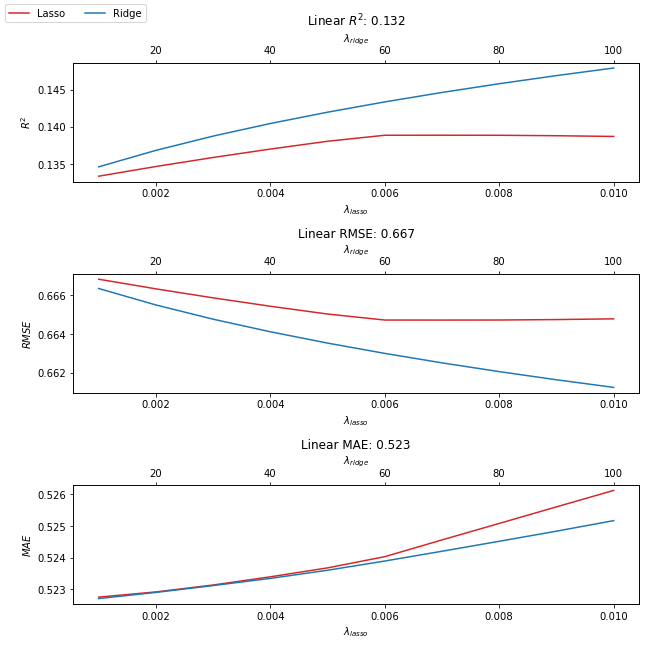

In [15]:
import matplotlib as MP
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

fig, axes = plt.subplots(3,1,figsize = (9,9))
n = 0


r2s_lasso = [r2_score(logger[n]['y_val'], yr) for yr in logger[n]['y_lasso']]
r2s_ridge = [r2_score(logger[n]['y_val'], yr) for yr in logger[n]['y_ridge']]

axes[0].plot(d_lasso_range, r2s_lasso, color = 'tab:red')
tax = axes[0].twiny()
tax.plot(d_ridge_range, r2s_ridge, color = 'tab:blue')
axes[0].set_xlabel('$\lambda_{lasso}$')
axes[0].set_ylabel('$R^2$')
tax.set_xlabel('$\lambda_{ridge}$')
linear_r2 = r2_score(logger[n]['y_val'], logger[n]['y_linear'])
axes[0].set_title(f'Linear $R^2$: {linear_r2:.3g}')

rmses_ridge = [mean_squared_error(logger[n]['y_val'], yr)**.5 for yr in logger[n]['y_ridge']]
rmses_lasso = [mean_squared_error(logger[n]['y_val'], yr)**.5 for yr in logger[n]['y_lasso']]

axes[1].plot(d_lasso_range, rmses_lasso, color = 'tab:red')
tax = axes[1].twiny()
tax.plot(d_ridge_range, rmses_ridge, color = 'tab:blue')
axes[1].set_xlabel('$\lambda_{lasso}$')
axes[1].set_ylabel('$RMSE$')
tax.set_xlabel('$\lambda_{ridge}$')
linear_rmse = mean_squared_error(logger[n]['y_val'], logger[n]['y_linear']) ** .5
axes[1].set_title(f'Linear RMSE: {linear_rmse:.3g}')

maes_ridge = [mean_absolute_error(logger[n]['y_val'], yr) for yr in logger[n]['y_ridge']]
maes_lasso = [mean_absolute_error(logger[n]['y_val'], yr) for yr in logger[n]['y_lasso']]

a1 = axes[2].plot(d_lasso_range, maes_lasso, color = 'tab:red')
tax = axes[2].twiny()
a2 = tax.plot(d_ridge_range, maes_ridge, color = 'tab:blue')
axes[2].set_xlabel('$\lambda_{lasso}$')
axes[2].set_ylabel('$MAE$')
tax.set_xlabel('$\lambda_{ridge}$')
linear_mae = mean_absolute_error(logger[n]['y_val'], logger[n]['y_linear'])
axes[2].set_title(f'Linear MAE: {linear_mae:.3g}')

fig.legend(
    [
        MP.patches.mlines.Line2D([],[], color = 'tab:red'),
        MP.patches.mlines.Line2D([],[], color = 'tab:blue')
    ],
    ['Lasso','Ridge'],
    loc = 'upper left', ncol = 2
)
fig.tight_layout()

Text(0, 0.5, '$\\beta_{ridge}$')

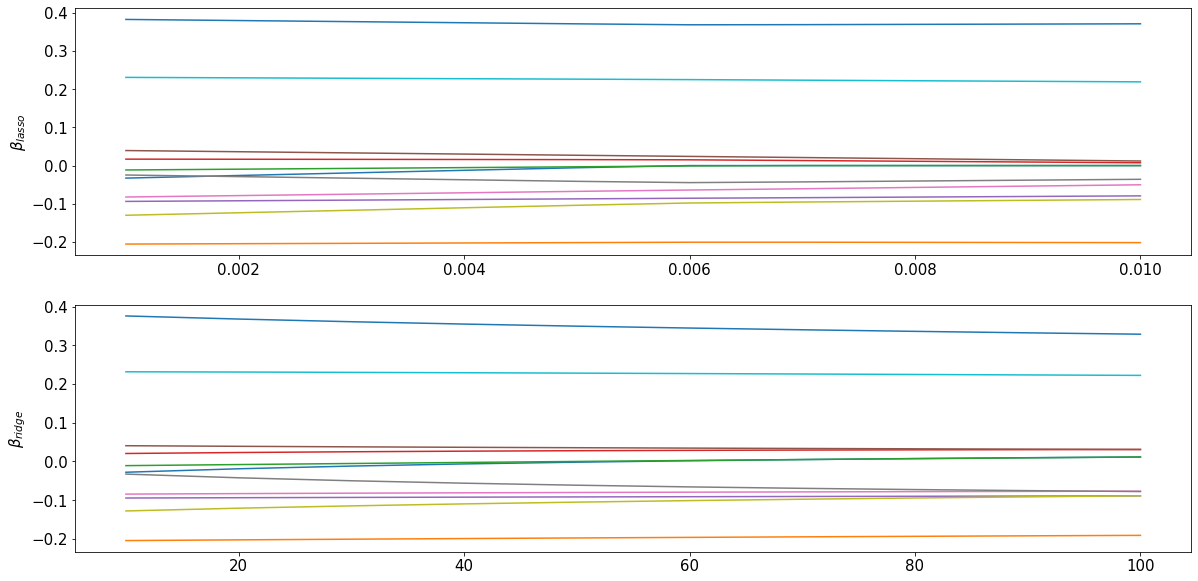

In [16]:
ridge_coeffs = [r.coef_[0] for r in logger[n]['ridge']]
lasso_coeffs = [r.coef_ for r in logger[n]['lasso']]

plt.rcParams['font.size'] = 15

fig,ax = plt.subplots(2,1,figsize = (20, 10))
for rcoef, lcoef in zip(
    np.stack(ridge_coeffs).transpose(),
    np.stack(lasso_coeffs).transpose(),
):
    ax[0].plot(d_lasso_range, lcoef)
    ax[1].plot(d_ridge_range, rcoef)
ax[0].set_ylabel(r"$\beta_{lasso}$")
ax[1].set_ylabel(r"$\beta_{ridge}$")